# Pipeline - School Roads - Road Points

The purpose of this notebook is to gather school road lat/lon points and relative bearing. These points provide a way to find street-level imagery from roads around schools.

The data collected by this notebook will later be used to determine whether specific segments of roads are near a school and if they are, to further analyze whether those roads have street-level signage indicating and warning drivers about the school zone. This data in turn is used to help automatically determine the iRAP 5-star attribute code for school signage.

## Imported Data

The assumption is that incoming data will be in .shp format and include Shapely linestring geometry for roads around schools

## Exported Data

Data exported from this notebook will be in parquet format and will eventually be used outside of this task.

In [1]:
# Parameters cell used to indicate parameters which will be used at runtime.
# Note: the below is a default parameter value which is overridden when the
# notebook is executed as part of a pipeline via Prefect + Papermill

name = "usa"
link = "https://nces.ed.gov/programs/edge/data/EDGE_GEOCODE_PUBLICSCH_1819.zip"
unzip = True
target = "EDGE_GEOCODE_PUBLICSCH_1819.xlsx"
lat_colname = "LAT"
lon_colname = "LON"

In [2]:
import os

import geopandas as gpd
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import shapely
import shapely.ops as sp_ops
from pyproj import Proj, Transformer
from shapely.geometry import LinearRing, LineString

ox.config(log_console=True, log_level=10, use_cache=True)

In [3]:
# ref https://gis.stackexchange.com/questions/372912/how-to-densify-linestring-vertices-in-shapely-geopandas
def densify_geometry (line_geometry, step, crs=None):

    # crs: epsg code of a coordinate reference system you want your line to be georeferenced with
    # step: add a vertice every step in whatever unit your coordinate reference system use.

    length_m=line_geometry.length # get the length

    xy=[] # to store new tuples of coordinates

    # changed to not use casted int for length_m
    for distance_along_old_line in np.arange(0,length_m,step): 

        point = line_geometry.interpolate(distance_along_old_line) # interpolate a point every step along the old line
        xp,yp = point.x, point.y # extract the coordinates
        
        xy.append((xp,yp)) # and store them in xy list

    #new_line=LineString(xy) # Here, we finally create a new line with densified points.

    if crs != None:  #  If you want to georeference your new geometry, uses crs to do the job.
        new_line_geo=gpd.geoseries.GeoSeries(new_line,crs=crs) 
        return new_line_geo

    else:
        return xy

In [4]:
def gather_road_points(gdf: gpd.GeoDataFrame) -> pd.DataFrame:
    
    # gather road latlon tuples based on road geometry linestring coords
    lats = []
    lons = []
    road_names = []
    road_lengths = []
    bearings = []
    for index, rrow in gdf[
        ~(gdf["geometry"].isna()) & ~(gdf["highway"] == "service")
    ].iterrows():
        
        densified_points = densify_geometry(rrow["geometry"], step= 0.0002)

        if len(densified_points) > 1:
            lats += [x[1] for x in densified_points]
            lons += [x[0] for x in densified_points]
            road_names += [rrow["name"] for x in densified_points]
            road_lengths += [rrow["length"] for x in densified_points]

            for x in range(0, len(densified_points)):

                # calculate bearings of the road
                if x == 0:
                    # if we're at the beginning of the road linestring,
                    # reverse the bearing source and targ to keep uniform bearings for data
                    bearing = ox.bearing.get_bearing(densified_points[x+1],densified_points[x])
                else:
                    bearing = ox.bearing.get_bearing(densified_points[x],densified_points[x-1])

                bearings.append(bearing)
                                             
    # create a dataframe to encapsulate data gathered above
    school_road_points_df = pd.DataFrame.from_dict({
            "road_name": road_names, 
            "lon": lons, 
            "lat": lats, 
            "road_length": road_lengths,
            "bearing":bearings
        }
    )
    
    return school_road_points_df

In [5]:
# read the shape file with road linestrings
gdf = gpd.read_parquet("{}/data/{}_school_roads.parquet".format(os.getcwd(), name))

In [6]:
# gather the densified road points
df = gather_road_points(gdf=gdf)
df.head()

,road_name,lon,lat,road_length,bearing
0,West Monroe Street,-87.679069,41.879973,200.845,0.037247
1,West Monroe Street,-87.679269,41.879970,200.845,0.037247
2,West Monroe Street,-87.679469,41.879967,200.845,0.037244
3,West Monroe Street,-87.679669,41.879963,200.845,0.037241
4,West Monroe Street,-87.679869,41.879960,200.845,0.037224


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   road_name    215 non-null    object 
 1   lon          215 non-null    float64
 2   lat          215 non-null    float64
 3   road_length  215 non-null    float64
 4   bearing      215 non-null    float64
dtypes: float64(4), object(1)
memory usage: 8.5+ KB


<AxesSubplot:title={'center':'Road Lat/Lon Around School'}, xlabel='lon', ylabel='lat'>

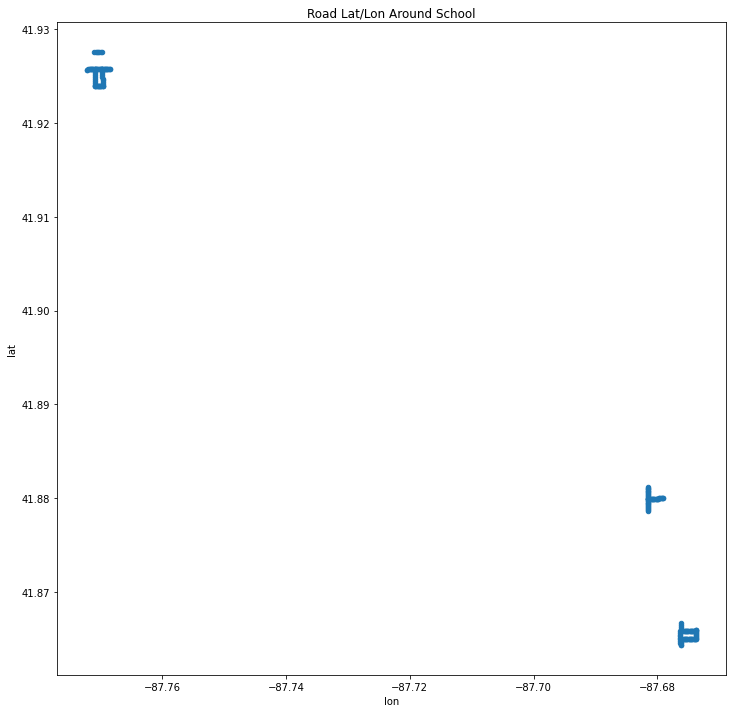

In [12]:
# create a plot for quick sketch of points involved
df.head(500)[["lat", "lon"]].plot(
    kind="scatter",
    x="lon",
    y="lat",
    figsize=(12, 12),
    title="Road Lat/Lon Around School",
)

In [13]:
df.to_parquet("{}/data/{}_school_road_points.parquet".format(os.getcwd(), name), index=False)